# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm

# using the SQLite Table to read data.
con = sqlite3.connect('../amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

C:\Users\Dell\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'i', 've', "needn't", 'where', 'no', 'are', 'does', 'further', 'then', 'them', "that'll", 'not', "should've", 'itself', 'themselves', 'than', "you're", 'couldn', 'hers', 'having', 'just', "wasn't", 'by', 'during', 'll', 'while', 'weren', 'those', 'until', 'there', 'both', "hadn't", 'will', 'its', 'shouldn', 'when', 'through', 'so', 'don', 'or', "couldn't", "mightn't", 'because', 'won', "you've", 'some', 're', 'been', "weren't", 'your', 'a', 'can', 'hasn', 'doesn', "shouldn't", 'he', 'as', 'yourselves', 'should', 'an', 'has', 'shan', 'they', 'against', "shan't", 'who', 'such', 'between', 'about', 'isn', 'down', 'how', "mustn't", 'their', 'most', 'ain', 'the', 'here', 'in', 'yours', 'it', "wouldn't", 'wasn', 'these', 'her', 'and', 'now', 'for', 'over', 'you', "haven't", 'needn', 'my', 'mustn', 'himself', 'wouldn', 'into', 'his', 'few', 'o', 'own', 'up', 'hadn', 'off', 'have', 'being', 'but', 'ma', 'herself', 'more', "she's", 'nor', 'm', 'had', 'which', 'didn', 'was', "isn't", 't', 'y', 

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final_np=final.head(100000)

In [15]:
final_np['Score'].value_counts()

positive    85197
negative    14803
Name: Score, dtype: int64

In [16]:
# Sorting data based on time
final_np["Time"] = pd.to_datetime(final_np["Time"], unit = "s")
final_np = final_np.sort_values(by = "Time")

In [17]:
final_np.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [18]:
def log_reg_grid(X_train,y_train):
    clf = LogisticRegression()
    #params we need to try on classifier
    param_grid = {'C':[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
                 'penalty':['l1','l2']} 
    gscv = GridSearchCV(clf,param_grid,cv=10,verbose=1,scoring='f1_micro',n_jobs=-1)
    gscv.fit(X_train,y_train)
    # Plotting HyperParameter Graph
    x1, x2, y1, y2 = ([] for i in range(4))
    for param in gscv.grid_scores_:
        if (param[0]['penalty']) == 'l1':
            y1.append(1-param[1])
            x1.append(param[0]['C'])
        else:
            y2.append(1-param[1])
            x2.append(param[0]['C'])
    plt.xlim(-5,110)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=10)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend(title='Penalty')
    plt.show()
    print("Best HyperParameter: ",gscv.best_params_)
    print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

In [19]:
def log_reg_rand(X_train,y_train):
    clf = LogisticRegression()
    #params we need to try on classifier
    param_grid = { 'C':[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
                  'penalty':['l1','l2']}
    rscv = RandomizedSearchCV(clf,param_grid,cv=10,verbose=1,scoring='f1_micro',n_jobs=-1)
    rscv.fit(X_train,y_train)
    # Plotting HyperParameter Graph
    x1, x2, y1, y2 = ([] for i in range(4))
    for param in rscv.grid_scores_:
        if (param[0]['penalty']) == 'l1':
            y1.append(1-param[1])
            x1.append(param[0]['C'])
        else:
            y2.append(1-param[1])
            x2.append(param[0]['C'])
    plt.xlim(-5,110)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=10)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend(title='Penalty')
    plt.show()
    print("Best HyperParameter: ",rscv.best_params_)
    print("Best Accuracy: %.2f%%"%(rscv.best_score_*100))

In [20]:
def confusion_matrix_np(cm):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix for MultinomialNB")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [21]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

# [7.2.2] Bag of Words (BoW)

In [22]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [23]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [25]:
import pickle as pkl

#to save it
with open("train.pkl", "wb") as f:
    pkl.dump([X_train, y_train], f)

#to save it
with open("test.pkl", "wb") as f:
    pkl.dump([X_test, y_test], f)  

## GridSearchCV

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)
X_test=count_vect.transform(X_test)
#Normalizing the dataset
X_train= preprocessing.normalize(X_train)
X_test= preprocessing.normalize(X_test)

In [27]:
#to save it
with open("train_bow.pkl", "wb") as f:
    pkl.dump([X_train,y_train], f)

#to save it
with open("test_bow.pkl", "wb") as f:
    pkl.dump([X_test,y_test], f) 

Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:  7.0min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


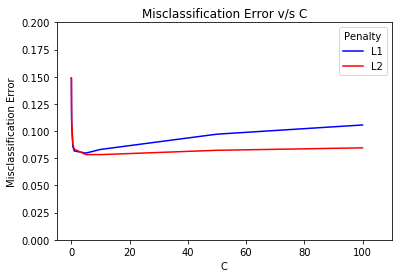

Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 92.17%


In [28]:
#LogRegGrid
lrg_bow= log_reg_grid(X_train, y_train)
lrg_bow

In [29]:
lg = LogisticRegression(C=10,penalty='l2')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [30]:
# Accuracy on train data
train_acc_bow = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 94.45142857142858


In [31]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  92.55666666666667


In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2875,  1512],
       [  721, 24892]], dtype=int64)

In [33]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.80      0.66      0.72      4387
   positive       0.94      0.97      0.96     25613

avg / total       0.92      0.93      0.92     30000



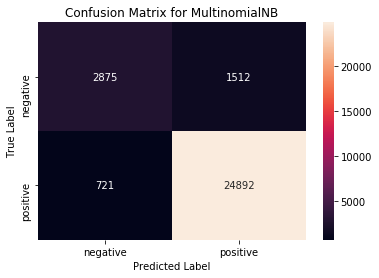

In [34]:
confusion_matrix_np(cm)

In [35]:
show_most_informative_features(count_vect,lg)

			Negative						Positive
________________________________________________________________________________________________
	-14.7144	worst          				9.1863	amaz           
	-10.4625	aw             				8.9109	delici         
	-10.3771	terribl        				8.8895	addict         
	-9.9762	tasteless      				8.6295	excel          
	-9.8756	wors           				8.5305	perfect        
	-9.7862	threw          				8.4474	best           
	-9.7683	horribl        				8.4056	awesom         
	-8.9745	bland          				8.1969	beat           
	-8.8465	disappoint     				7.6961	yummi          
	-8.5538	return         				7.5223	uniqu          
	-8.5089	flavorless     				7.2754	satisfi        
	-8.4101	refund         				7.1365	yum            
	-8.1629	disgust        				7.1232	great          
	-8.0650	cancel         				7.0515	hook           
	-7.9131	unfortun       				6.9221	delight        
	-7.5998	gross          				6.8411	skeptic        
	-7.4439	inferior       				6.7624	fantast        
	-7.394

## Pertubation Test

In [36]:
clf1 = LogisticRegression(C=5, penalty='l2')
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf1.score(X_train, y_train)*100))

Accuracy on test set: 93.860%


In [37]:
clf1.coef_.size

31433

In [38]:
#Adding Noise
X_train_t=X_train
epsilon = np.random.uniform(low=-0.01, high=0.01, size=X_train.size)
X_train_t.data += epsilon

In [39]:
#Training on train data having random noise
clf2 = LogisticRegression(C=5, penalty='l2' )
clf2.fit(X_train_t,y_train)
y_pred = clf2.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf2.score(X_test, y_test)*100))

Accuracy on test set: 92.470%


In [40]:
clf2.coef_.size

31433

In [41]:
weights_diff = (abs(clf1.coef_-clf2.coef_)/clf1.coef_) * 100

In [42]:
print(weights_diff[np.where(weights_diff > 30)].size)

710


In [43]:
#to load it
with open("train_bow.pkl", "rb") as f:
    X_train,y_train = pkl.load(f)
    
#to load it
with open("test_bow.pkl", "rb") as f:
    X_test,y_test = pkl.load(f)

## RandomizedSearchCV

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


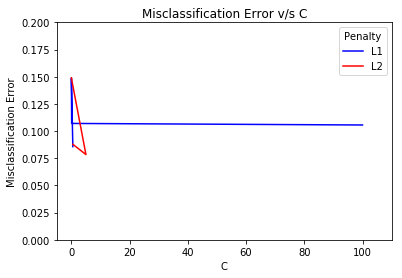

Best HyperParameter:  {'penalty': 'l2', 'C': 5}
Best Accuracy: 92.16%


In [44]:
#LogRegGrand
lrg_bow= log_reg_rand(X_train, y_train)
lrg_bow

In [45]:
lg = LogisticRegression(C=5,penalty='l1' )
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [46]:
# Accuracy on train data
train_acc_bow = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 94.31714285714285


In [47]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  92.44333333333333


In [48]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2911,  1476],
       [  791, 24822]], dtype=int64)

In [49]:
# Classification report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.79      0.66      0.72      4387
   positive       0.94      0.97      0.96     25613

avg / total       0.92      0.92      0.92     30000



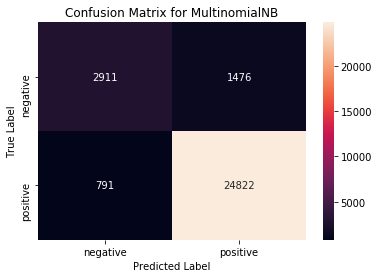

In [50]:
confusion_matrix_np(cm)

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [51]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [52]:
#to load it
with open("train.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
    
#to load it
with open("test.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

# GridSearchCV

In [53]:
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
X_train = count_vect.fit_transform(X_train)
X_test=count_vect.transform(X_test)
#Normalizing the dataset
X_train= preprocessing.normalize(X_train)
X_test= preprocessing.normalize(X_test)

In [54]:
#to save it
with open("train_bowo.pkl", "wb") as f:
    pkl.dump([X_train,y_train], f)

#to save it
with open("test_bowo.pkl", "wb") as f:
    pkl.dump([X_test,y_test], f) 

Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed: 20.2min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


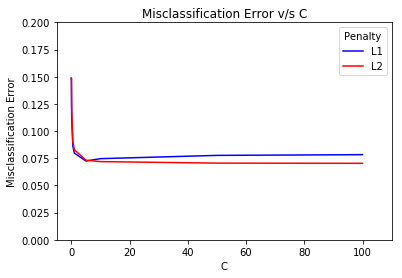

Best HyperParameter:  {'C': 100, 'penalty': 'l2'}
Best Accuracy: 92.97%


In [55]:
#LogRegGrid
lrg_bow= log_reg_grid(X_train, y_train)
lrg_bow

In [56]:
lg = LogisticRegression(C=100,penalty='l2')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [57]:
# Accuracy on train data
train_acc_bow = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 100.0


In [58]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)


Test Accuracy  93.38333333333333


In [59]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 3045,  1342],
       [  643, 24970]], dtype=int64)

In [60]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.83      0.69      0.75      4387
   positive       0.95      0.97      0.96     25613

avg / total       0.93      0.93      0.93     30000



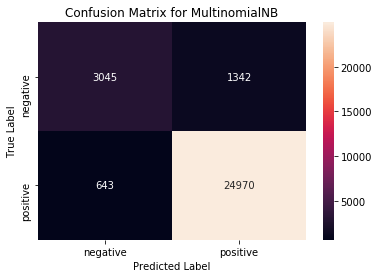

In [61]:
confusion_matrix_np(cm)

In [62]:
show_most_informative_features(count_vect,lg)

			Negative						Positive
________________________________________________________________________________________________
	-25.7260	worst          				18.4948	high recommend 
	-18.2254	aw             				16.3019	delici         
	-18.1366	disappoint     				16.0958	wont disappoint
	-18.1005	terribl        				14.8662	amaz           
	-17.4127	horribl        				14.4552	excel          
	-16.7591	threw          				14.3843	perfect        
	-16.7059	bland          				14.3349	addict         
	-15.9998	two star       				13.9342	best           
	-15.9576	wors           				13.4767	awesom         
	-15.5075	tasteless      				12.5072	even better    
	-15.1397	wont buy       				12.3682	never disappoint
	-15.0111	great review   				12.3408	satisfi        
	-14.4035	return         				12.2693	yummi          
	-14.0103	disgust        				12.0314	beat           
	-13.8353	unfortun       				11.7840	hook           
	-13.5295	shame          				11.6856	nice           
	-13.5238	refund         			

# Pertubation Test

In [63]:
clf1 = LogisticRegression(C=50, penalty='l2')
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf1.score(X_train, y_train)*100))

Accuracy on test set: 99.994%


In [64]:
clf1.coef_.size

953204

In [65]:
#Adding Noise
X_train_t=X_train
epsilon = np.random.uniform(low=-0.01, high=0.01, size=X_train.size)
X_train_t.data += epsilon

In [68]:
#Training on train data having random noise
clf2 = LogisticRegression(C=100, penalty='l2' )
clf2.fit(X_train_t,y_train)
y_pred = clf2.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf2.score(X_test, y_test)*100))

Accuracy on test set: 93.327%


In [69]:
clf2.coef_.size

953204

In [70]:
weights_diff = (abs(clf1.coef_-clf2.coef_)/clf1.coef_) * 100

In [71]:
print(weights_diff[np.where(weights_diff > 30)].size)

179323


In [72]:
#to load it
with open("train_bowo.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
    
#to load it
with open("test_bowo.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

## RandomizedSearchCV

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


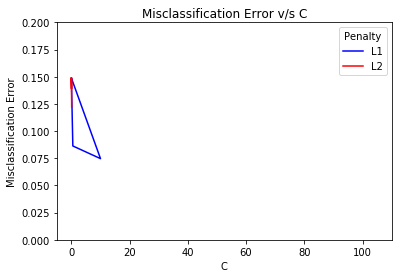

Best HyperParameter:  {'penalty': 'l1', 'C': 10}
Best Accuracy: 92.53%


In [73]:
#LogRegRand
lrg_bow= log_reg_rand(X_train, y_train)
lrg_bow


In [74]:
lg = LogisticRegression(C=10,penalty='l1')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [75]:
# Accuracy on train data
train_acc_bow = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 98.91


In [76]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)


Test Accuracy  92.83666666666667


In [77]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 3123,  1264],
       [  885, 24728]], dtype=int64)

In [78]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.78      0.71      0.74      4387
   positive       0.95      0.97      0.96     25613

avg / total       0.93      0.93      0.93     30000



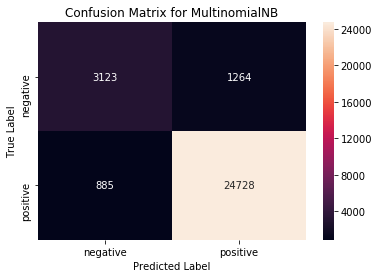

In [79]:
confusion_matrix_np(cm)

In [80]:
show_most_informative_features(count_vect,lg)

			Negative						Positive
________________________________________________________________________________________________
	-57.8455	cup equal      				34.1070	garbag can     
	-51.6957	two star       				32.9854	let review     
	-38.3708	store alreadi  				31.0072	assum get      
	-37.3793	pumpkin use    				29.6217	pleasant surpris
	-36.5838	extrem effect  				28.4000	box stale      
	-36.0156	babi new       				27.1869	get stale      
	-34.9152	forgot add     				27.0245	bolivia        
	-34.0832	flavor defin   				26.8594	list item      
	-33.6576	bizarr         				24.9640	sweet salti    
	-32.9561	way sweet      				24.7411	receiv basket  
	-32.8265	compass        				24.5999	one hard       
	-31.7217	calori littl   				24.0326	buy pet        
	-31.6169	tri instead    				23.8818	refund replac  
	-30.7681	usual love     				23.6421	wont disappoint
	-29.9299	like cheddar   				23.3104	tad            
	-29.7922	make beverag   				23.2056	toy unless     
	-29.2644	pizza burrito  			

# [7.2.5] TF-IDF

In [81]:
#to load it
with open("train.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
    
#to load it
with open("test.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

# GridSearchCV

In [82]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_test = tf_idf_vect.transform(X_test)
#Normalizing the dataset
X_train= preprocessing.normalize(X_train)
X_test= preprocessing.normalize(X_test)

In [83]:
#to save it
with open("train_tfidf.pkl", "wb") as f:
    pkl.dump([X_train,y_train], f)

#to save it
with open("test_tfidf.pkl", "wb") as f:
    pkl.dump([X_test,y_test], f) 


Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:  5.9min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


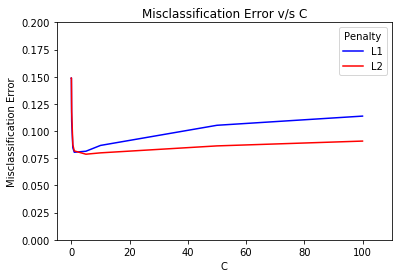

Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 92.13%


In [84]:
#LogRegGrid
lrg_tfidf= log_reg_grid(X_train, y_train)
lrg_tfidf

In [85]:
lg = LogisticRegression(C=5,penalty='l2')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [86]:
# Accuracy on train data
train_acc_tfidf = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidf*100)

Train Accuracy 94.85


In [87]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidf)


Test Accuracy  92.43666666666667


In [88]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2820,  1567],
       [  702, 24911]], dtype=int64)

In [89]:
# Classification report
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

   negative       0.80      0.64      0.71      4387
   positive       0.94      0.97      0.96     25613

avg / total       0.92      0.92      0.92     30000



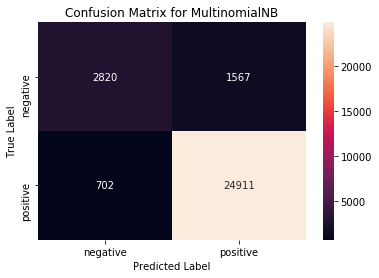

In [90]:
confusion_matrix_np(cm)

In [91]:
show_most_informative_features(count_vect,lg)

			Negative						Positive
________________________________________________________________________________________________
	-11.3949	anni weve      				13.2451	afford weve    
	-9.4218	add uncook     				12.3537	account peopl  
	-8.4570	amazon small   				11.0542	albeit flavor  
	-8.2042	accept tradeoff				10.9214	add lime       
	-7.7986	age bought     				9.8744	alot extra     
	-7.7013	amazon yet     				9.2111	adjust height  
	-7.5239	anni usual     				8.6033	absolut better 
	-7.4137	altern discontinu				7.5933	almond tast    
	-7.4091	aceton spoon   				7.5629	abj            
	-7.0653	amazon pass    				7.1999	accept well    
	-6.7971	amount gone    				6.8108	anoth counter  
	-6.4777	also think     				6.7676	affili receiv  
	-6.1651	add yoghurt    				6.5406	adopt anoth    
	-5.9553	act special    				6.4291	accomplish chewer
	-5.9476	alley delici   				6.3863	although opinion
	-5.9462	amaz pamela    				6.0192	addit dietari  
	-5.9251	adult rear     				5.9529	afar could     


# Pertubation Test

In [92]:
clf1 = LogisticRegression(C=5, penalty='l2')
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf1.score(X_train, y_train)*100))

Accuracy on test set: 94.850%


In [93]:
clf1.coef_.size

31433

In [94]:
#Adding Noise
X_train_t=X_train
epsilon = np.random.uniform(low=-0.01, high=0.01, size=X_train.size)
X_train_t.data += epsilon

In [95]:
#Training on train data having random noise
clf2 = LogisticRegression(C=5, penalty='l2' )
clf2.fit(X_train_t,y_train)
y_pred = clf2.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf2.score(X_test, y_test)*100))

Accuracy on test set: 92.430%


In [96]:
clf2.coef_.size

31433

In [97]:
weights_diff = (abs(clf1.coef_-clf2.coef_)/clf1.coef_) * 100

In [98]:
print(weights_diff[np.where(weights_diff > 30)].size)

581


In [99]:
#to load it
with open("train_tfidf.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
    
#to load it
with open("test_tfidf.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

# RandomizedSearchCV

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


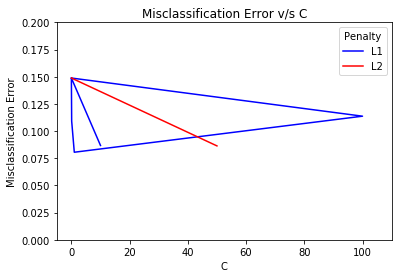

Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 91.95%


In [100]:
#LogRegRand
lrg_tfidf= log_reg_rand(X_train, y_train)
lrg_tfidf

In [101]:
lg = LogisticRegression(C=1,penalty='l1')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [102]:
# Accuracy on train data
train_acc_tfidf = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidf*100)

Train Accuracy 92.84428571428572


In [103]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidf)

Test Accuracy  92.30666666666667


In [104]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2713,  1674],
       [  634, 24979]], dtype=int64)

In [105]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.81      0.62      0.70      4387
   positive       0.94      0.98      0.96     25613

avg / total       0.92      0.92      0.92     30000



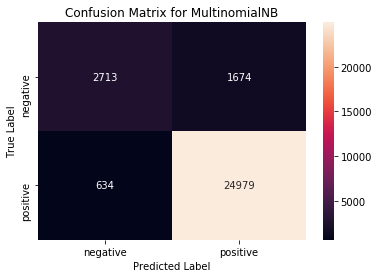

In [106]:
confusion_matrix_np(cm)

In [107]:
show_most_informative_features(count_vect,lg)

			Negative						Positive
________________________________________________________________________________________________
	-13.0520	anni weve      				13.7749	afford weve    
	-9.7435	add uncook     				13.3872	account peopl  
	-9.2363	accept tradeoff				12.1112	add lime       
	-8.8243	amazon small   				11.4557	albeit flavor  
	-8.7169	amazon yet     				11.2974	alot extra     
	-8.4881	anni usual     				10.0550	adjust height  
	-8.4192	age bought     				9.8358	absolut better 
	-7.7088	altern discontinu				8.2966	abj            
	-7.6700	amazon pass    				8.1371	accept well    
	-7.5421	also think     				7.9819	accomplish chewer
	-7.4916	aceton spoon   				7.9531	almond tast    
	-6.9814	adult rear     				7.6241	anoth counter  
	-6.8674	amount gone    				7.0448	amount jasmin  
	-6.8480	add yoghurt    				6.9326	adopt anoth    
	-6.4257	act special    				6.7887	affili receiv  
	-6.1046	amaz pamela    				6.7540	although opinion
	-6.0423	amount medicin 				6.5974	add magic     

# [7.2.6] Word2Vec

In [108]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

from gensim.models import Word2Vec
from gensim.models import KeyedVectors


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell


#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#print("the vector representation of word 'computer'",model.wv['computer'])
#print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
#print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [109]:
#to load it
with open("train.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
    
#to load it
with open("test.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

In [110]:
# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

In [111]:
print(X_train.values)
print("*****************************************************************")
print(list_of_sent[0])

['great chicken wing steak surpris pork tri fish next love dri rub sure purchas size buy first two bbqs'
 'best bread have tri make food processor great betsi'
 'love beefier chunkier chili blend season simpli savori less assault tastebud hormel opinion goe great hot dog bake potato good dip tortilla chip wonder companion grill chees sandwich toast english muffin'
 ...
 'settl assort get want everi time reach box actual bought halloween candi big hit'
 'cat alway love milk knew wasnt good tummi found love look like babi formula appar kitti cant tell differ nice treat otherwis finicki cat'
 'food great breed even larg bernes mountain dog two shetland sheepdog love food feed year great stuff']
*****************************************************************
['great', 'chicken', 'wing', 'steak', 'surpris', 'pork', 'tri', 'fish', 'next', 'love', 'dri', 'rub', 'sure', 'purchas', 'size', 'buy', 'first', 'two', 'bbqs']


In [112]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [113]:
w2v = w2v_model[w2v_model.wv.vocab]
w2v.shape

(10687, 50)

In [114]:
# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent_test.append(filtered_sentence)

In [115]:
print(X_test.values)
print("*****************************************************************")
print(list_of_sent_test[0])

['tri orang tea hook problem dont tea area thank check amazon price excel tea caffein free purchas amazon two time ship fast tea fresh dont mistak tea one say orang spice one spici mild good orang use teaspoon honey mine best ever would high recommend tea'
 'love product use food skin lip work well great valu'
 'candi great cost freight montana high candi' ...
 'coffe sooo good wish offer ground coffe though bit pricey pkg'
 'omg best cake ever gluten free tast even better regular chocol cake mix could easier make year old help mix ingredi dont understand star review dont overmix follow recip precis turn'
 'like tea littl caffein use pearl nice refresh tast brand tast nice guest alway said best ever']
*****************************************************************
['tri', 'orang', 'tea', 'hook', 'problem', 'dont', 'tea', 'area', 'thank', 'check', 'amazon', 'price', 'excel', 'tea', 'caffein', 'free', 'purchas', 'amazon', 'two', 'time', 'ship', 'fast', 'tea', 'fresh', 'dont', 'mistak',

In [116]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [117]:
w2v = w2v_model[w2v_model.wv.vocab]
w2v.shape

(10687, 50)

# [7.2.7] Avg W2V

In [118]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:   
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        except:
            pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


70000
50


In [119]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:   
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        except:
            pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [120]:
X_train = sent_vectors
X_test = sent_vectors_test
#Normalizing the dataset
X_train= preprocessing.normalize(X_train)
X_test= preprocessing.normalize(X_test)

In [121]:
#to save it
with open("train_avgw2v.pkl", "wb") as f:
    pkl.dump([X_train,y_train], f)

#to save it
with open("test_avgw2v.pkl", "wb") as f:
    pkl.dump([X_test,y_test], f) 

# GridSearchCV

Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:  2.2min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


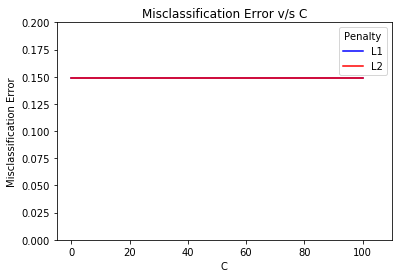

Best HyperParameter:  {'C': 100, 'penalty': 'l1'}
Best Accuracy: 85.12%


In [122]:
#LogRegGrid
lrg_avgw2v= log_reg_grid(X_train, y_train)
lrg_avgw2v

In [123]:
lg = LogisticRegression(C=100,penalty='l1')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [124]:
# Accuracy on train data
train_acc_avgw2v = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_avgw2v*100)

Train Accuracy 85.11999999999999


In [125]:
# Accuracy on test data
test_acc_avgw2v = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_avgw2v)

Test Accuracy  85.37666666666667


In [126]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[    0,  4387],
       [    0, 25613]], dtype=int64)

In [127]:
# Classification report
print(classification_report(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      4387
   positive       0.85      1.00      0.92     25613

avg / total       0.73      0.85      0.79     30000



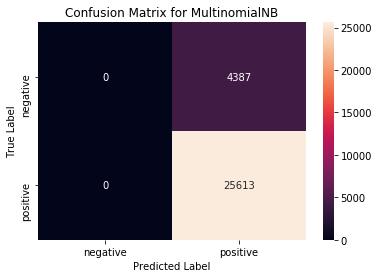

In [128]:
confusion_matrix_np(cm)

# Pertubation Test

In [129]:
clf1 = LogisticRegression(C=100, penalty='l1')
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf1.score(X_train, y_train)*100))

Accuracy on test set: 85.120%


In [130]:
clf1.coef_.size

50

In [131]:
#Adding Noise
X_train_t=X_train
#epsilon = np.random.uniform(low=-0.01, high=0.01, size=X_train.size)
X_train_t += 0.1

In [132]:
#Training on train data having random noise
clf2 = LogisticRegression(C=100, penalty='l1' )
clf2.fit(X_train_t,y_train)
y_pred = clf2.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf2.score(X_test, y_test)*100))


Accuracy on test set: 85.377%


In [133]:
clf2.coef_.size

50

In [134]:
weights_diff = (abs(clf1.coef_-clf2.coef_)/clf1.coef_) * 100

In [135]:
print(weights_diff[np.where(weights_diff > 30)].size)

6


In [136]:
#to load it
with open("train_avgw2v.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
    
#to load it
with open("test_avgw2v.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

# RandomizedSearchCV

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


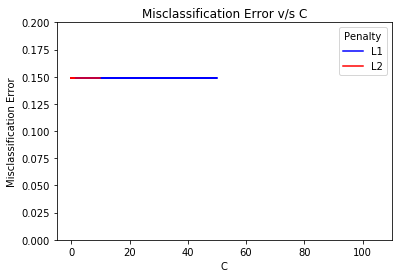

Best HyperParameter:  {'penalty': 'l1', 'C': 0.05}
Best Accuracy: 85.12%


In [137]:
#LogRegRand
lrg_tfidf= log_reg_rand(X_train, y_train)
lrg_tfidf

In [138]:
lg = LogisticRegression(C=0.05,penalty='l1')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [139]:
# Accuracy on train data
train_acc_tfidf = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidf*100)

Train Accuracy 85.11999999999999


In [140]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidf)

Test Accuracy  85.37666666666667


In [141]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[    0,  4387],
       [    0, 25613]], dtype=int64)

In [142]:
# Classification report
print(classification_report(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      4387
   positive       0.85      1.00      0.92     25613

avg / total       0.73      0.85      0.79     30000



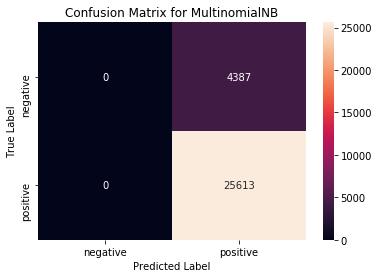

In [143]:
confusion_matrix_np(cm)

# TFIDF-W2V

In [144]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [145]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 70000/70000 [00:03<00:00, 21389.43it/s]


In [146]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 70000/70000 [00:02<00:00, 26948.91it/s]


In [147]:
X_train = sent_vectors
X_test = sent_vectors_test
#Normalizing the dataset
X_train= preprocessing.normalize(X_train)
X_test= preprocessing.normalize(X_test)

In [148]:
#to save it
with open("train_tfidfw2v.pkl", "wb") as f:
    pkl.dump([X_train,y_train], f)

#to save it
with open("test_tfidfw2v.pkl", "wb") as f:
    pkl.dump([X_test,y_test], f) 

# GridSearchCV

Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:  3.3min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


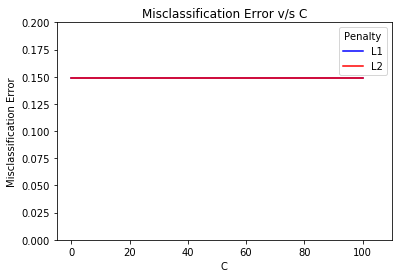

Best HyperParameter:  {'C': 100, 'penalty': 'l1'}
Best Accuracy: 85.12%


In [149]:
#LogRegGrid
lrg_tfidfw2v= log_reg_grid(X_train, y_train)
lrg_tfidfw2v

In [150]:
lg = LogisticRegression(C=100,penalty='l1')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [151]:
# Accuracy on train data
train_acc_tfidfw2v = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidfw2v*100)

Train Accuracy 85.11999999999999


In [152]:
# Accuracy on test data
test_acc_tfidfw2v = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidfw2v)

Test Accuracy  85.37666666666667


In [153]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[    0,  4387],
       [    0, 25613]], dtype=int64)

In [154]:
# Classification report
print(classification_report(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      4387
   positive       0.85      1.00      0.92     25613

avg / total       0.73      0.85      0.79     30000



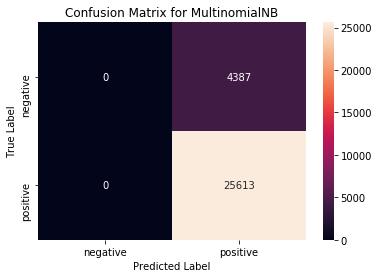

In [155]:
confusion_matrix_np(cm)

# Perturbation Test

In [156]:
clf1 = LogisticRegression(C=100, penalty='l1')
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf1.score(X_train, y_train)*100))

Accuracy on test set: 85.120%


In [157]:
clf1.coef_.size

50

In [158]:
#Adding Noise
X_train_t=X_train
#epsilon = np.random.uniform(low=-0.01, high=0.01, size=X_train.size)
X_train_t += 0.1

In [159]:
#Training on train data having random noise
clf2 = LogisticRegression(C=100, penalty='l1' )
clf2.fit(X_train_t,y_train)
y_pred = clf2.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(clf2.score(X_test, y_test)*100))

Accuracy on test set: 85.377%


In [160]:
clf2.coef_.size

50

In [161]:
weights_diff = (abs(clf1.coef_-clf2.coef_)/clf1.coef_) * 100

In [162]:
print(weights_diff[np.where(weights_diff > 30)].size)

7


In [163]:
#to load it
with open("train_tfidfw2v.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)
    
#to load it
with open("test_tfidfw2v.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

# RandomizedSearchCV

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


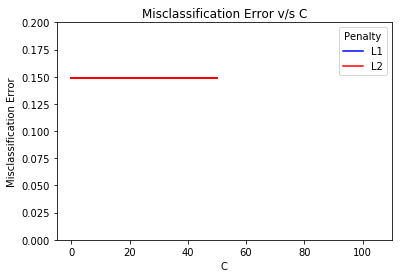

Best HyperParameter:  {'penalty': 'l1', 'C': 0.05}
Best Accuracy: 85.12%


In [164]:
#LogRegRand
lrg_tfidfw2v= log_reg_rand(X_train, y_train)
lrg_tfidfw2v

In [165]:
lg = LogisticRegression(C=0.05,penalty='l1')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)

In [166]:
# Accuracy on train data
train_acc_tfidfw2v = lg.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidfw2v*100)


Train Accuracy 85.11999999999999


In [167]:
# Accuracy on test data
test_acc_tfidfw2v = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidfw2v)

Test Accuracy  85.37666666666667


In [168]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[    0,  4387],
       [    0, 25613]], dtype=int64)

In [169]:
# Classification report
print(classification_report(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      4387
   positive       0.85      1.00      0.92     25613

avg / total       0.73      0.85      0.79     30000



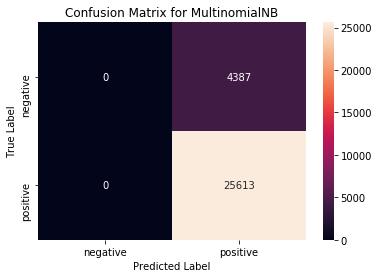

In [170]:
confusion_matrix_np(cm)

# Conclusion
* Bigram Vectorizer performs well with test accuracy equal to 93.38% and f1-score 0.93.
* Pertubation test shows that adding noise to the model, it does affect the model's accuracy.

In [171]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer","Algorithm","C","Penalty","Train Accuracy","Test Accuracy","F-1 Score"]

x.add_row(["Unigram BOW", "GridSearchCV",10,"l2",94.45,92.56,0.92])
x.add_row(["Unigram BOW", "RandomizedCV",5,"l1",94.31,92.44,0.92])
x.add_row(["Bigram BOW", "GridSearchCV",100,"l2",100,93.38,0.93])
x.add_row(["Bigram BOW", "RandomizedCV",10,"l1",98.91,92.83,0.93])
x.add_row(["TF-IDF", "GridSearchCV",5,"l2",94.85,92.43,0.92])
x.add_row(["TF-IDF", "RandomizedCV",1,"l1",92.84,92.30,0.92])
x.add_row(["AVG-W2V", "GridSearchCV",100,"l1",85.11,85.37,0.79])
x.add_row(["AVG-W2V", "RandomizedCV",0.05,"l1",85.11,85.37,0.79])
x.add_row(["TFIDF-W2V", "GridSearchCV",100,"l1",85.11,85.37,0.79])
x.add_row(["TFIDF-W2V", "RandomizedCV",0.1,"l1",85.11,85.37,0.79])

print("Performance Table")
print(x)



Performance Table
+-------------+--------------+------+---------+----------------+---------------+-----------+
|  Vectorizer |  Algorithm   |  C   | Penalty | Train Accuracy | Test Accuracy | F-1 Score |
+-------------+--------------+------+---------+----------------+---------------+-----------+
| Unigram BOW | GridSearchCV |  10  |    l2   |     94.45      |     92.56     |    0.92   |
| Unigram BOW | RandomizedCV |  5   |    l1   |     94.31      |     92.44     |    0.92   |
|  Bigram BOW | GridSearchCV | 100  |    l2   |      100       |     93.38     |    0.93   |
|  Bigram BOW | RandomizedCV |  10  |    l1   |     98.91      |     92.83     |    0.93   |
|    TF-IDF   | GridSearchCV |  5   |    l2   |     94.85      |     92.43     |    0.92   |
|    TF-IDF   | RandomizedCV |  1   |    l1   |     92.84      |      92.3     |    0.92   |
|   AVG-W2V   | GridSearchCV | 100  |    l1   |     85.11      |     85.37     |    0.79   |
|   AVG-W2V   | RandomizedCV | 0.05 |    l1   |     